0 1
1 12
2 60
3 162
4 255
5 234
6 116
7 24


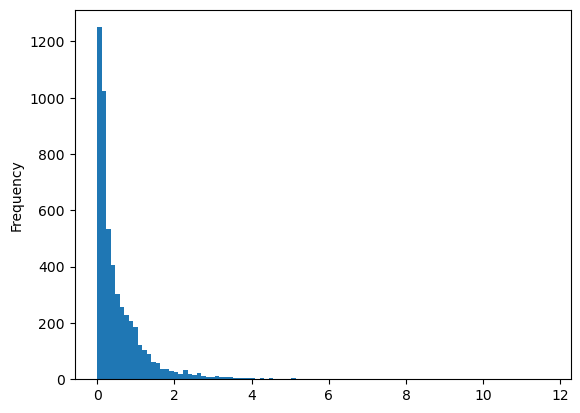

In [1]:
#Generate sequences for all mutations in deep mutational scan covid spike RBD experiment 
#! pip install Bio
import pandas as pd
import Bio
from Bio import SeqIO
from Bio import SeqRecord
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import matplotlib.pyplot as plt
from Bio.Seq import MutableSeq
import numpy as np
#import tabulate

# read and get fitness
file = '../data/NA_compile_results.tsv'
df = pd.read_csv(file, sep="\t") 

plt.figure()
df['fit'].plot.hist(bins=100)
#print(min(df['fit']), max(df['fit']))

# pick a single strain background, since landscapes are highly correlated among the strains
df = df[df['strain'] == 'HK19']
#print(df)
recs = df.to_dict('records')
#print(recs)
wt = 'KSENETS' # HK19 seq

# calculate Hamming distances
def aa_dist(wt, hap):
    d = 0;
    for i in range(len(wt)):
        if wt[i] != hap[i]:
            d += 1
    return(d)

#print(aa_dist(wt, 'NDEGEEL'))

wtDict = {}
for rec in recs:
    wtDict[rec['ID']] = {'fit': rec['fit'], 'charge': rec['charge'], 'subset': aa_dist(wt, rec['ID'])}
#print(wtDict)
for level in range(8):
    ndPre = [id for id in  wtDict if wtDict[id]['subset'] == level]
    print(level, len(ndPre))
    
df.to_csv("../data/na-subset.tsv", sep = "\t", index = False)

In [2]:
# build a directed graph
import networkx as nx

DG = nx.DiGraph() # a directed graph, there is lots of graph algorithms to identify local and global peaks; apply evol algo

# add nodes
for id in wtDict: 
    DG.add_node(id) # add a node with a string name (id)        
    for k in wtDict[id]: # attach features: fit, charge, subset 
        DG.nodes[id][k] = wtDict[id][k]

for level in range(8): # add edge
    ndPre = [id for id in  wtDict if wtDict[id]['subset'] == level]
    ndThis = [id for id in  wtDict if wtDict[id]['subset'] == level + 1]
    #print(ndPre)
    #print(ndThis)
    
    for i in ndPre:
        for j in ndThis:
            if aa_dist(i, j) == 1:
                if wtDict[i]['fit'] < wtDict[j]['fit']: # higher bind for mut    
                    DG.add_edge(i, j)
                else:
                    DG.add_edge(j, i)
#print(len(DG.nodes))
#print(len(DG.edges))
peaks = [x[0] for x in DG.out_degree if x[1] == 0]
vals = [x[0] for x in DG.in_degree if x[1] == 0]
for y in sorted([ x for x in peaks], key = lambda n: DG.nodes[n]['fit']):
    print(y, "\t", DG.nodes[y]['fit'])

#print(len(vals))

KNKGKKL 	 0.1887359572142007
KNRGKEL 	 0.3577578425225995
NNKGEES 	 0.7800717813061993
NNEGEKS 	 1.0272327619000765
KNRNEDS 	 1.1795843264522965
NDRGKES 	 1.2125549298647629
NDEGETL 	 1.2144673529254142
NNRGEES 	 1.3474350137123572
KSKGEES 	 1.481657623339101
KDKSKDL 	 1.7044394885444454
NDKNKES 	 1.7709132628504975
NNESETS 	 1.9452364636028316
NNRSEES 	 2.0197196046073564
KDRNKEL 	 2.173138570439968
KDRGEES 	 2.310331381302156
NSRGETS 	 2.4157322873794387
NNKGEDS 	 2.458292238181788
KDRNKDL 	 2.55330235677663
KDKNEEL 	 2.6489943078809817
KSKGEDS 	 2.7424181421060783
NSRNKDS 	 2.76871635122034
NDESKDS 	 2.815455924766102
KDRNETL 	 3.0492707883066776
NDRNKTS 	 3.0724538451030434
KDESKKS 	 3.28220082102829
NDRNEES 	 3.3960588517028274
KSKNETS 	 3.586734702621825
NSESEKS 	 3.974072177206089
KSRSEDS 	 4.224298110518875
NDRSETL 	 4.468040526031023
KDKNEDL 	 4.670968702406463
NDKSKTS 	 4.786828287683896
NDKSEDS 	 4.859727832973142
NSRSETS 	 5.047178170062178
KDENEDS 	 5.065745967811848
NDRSE

In [3]:
# Landscape analysis
# Basin of Attraction (=> is it correlated with probability of local peak); length of chains of steepest climb
# deterministic measure (Algorithm 1 of https://bird.bcamath.org/bitstream/handle/20.500.11824/314/CAEPIA167.pdf?sequence=1)
# Or by: Simoncini et al 2018; https://doi.org/10.1145/3205455.3205626
# Local Optimal Network: linked by escape-edges or by basin-edges

def fit_diff(G, nd, pre):
    return G.nodes[nd]['fit'] - G.nodes[pre]['fit'] # must be positive

# recursive function
def greedy_descent(G, nd, pt):
    if nd in vals: # a valley, no predecessors
        pt.append(nd)
        return
    best = sorted( [ pre for pre in G.predecessors(nd)], key = lambda x: fit_diff(G, nd, x), reverse = True) # for each m -> n
    pt.append(best[0])
    greedy_descent(G, best[0], pt)

for peak in sorted(peaks):
    path = []
    print(peak, "=>", end = "\t")
    greedy_descent(DG, peak, path)
    print(path)

KDENEDS =>	['NDENEDS', 'NDEGEDS', 'NDEGEDL', 'NDEGEDL']
KDENEKS =>	['KDKNEKS', 'KDKNKKS', 'KDKGKKS', 'KDKGKKL', 'KDKGKKL']
KDESKKS =>	['KDRSKKS', 'KDRNKKS', 'KDRGKKS', 'KDRGKKS']
KDKNEDL =>	['KDKGEDL', 'KDEGEDL', 'NDEGEDL', 'NDEGEDL']
KDKNEEL =>	['KSKNEEL', 'KSKNKEL', 'KSKGKEL', 'KNKGKEL', 'NNKGKEL', 'NNKGKEL']
KDKSKDL =>	['KSKSKDL', 'KSKSKTL', 'KNKSKTL', 'KNKSKTL']
KDRGEES =>	['KDRGEEL', 'KSRGEEL', 'KSRGEEL']
KDRNETL =>	['KDRGETL', 'KDRGEKL', 'KSRGEKL', 'KNRGEKL', 'KNRGEKL']
KDRNKDL =>	['KDRGKDL', 'NDRGKDL', 'NDRGKTL', 'NDRGKTL']
KDRNKEL =>	['KDRGKEL', 'KSRGKEL', 'KSRGEEL', 'KSRGEEL']
KDRSETS =>	['KDRSKTS', 'KDRSKTL', 'KSRSKTL', 'KSRSKTL']
KNKGKKL =>	['KSKGKKL', 'KSKGEKL', 'KSKGEKL']
KNRGKEL =>	['KNEGKEL', 'KNKGKEL', 'NNKGKEL', 'NNKGKEL']
KNRNEDS =>	['KNRNKDS', 'KNRGKDS', 'KNRGKDL', 'KNRGKDL']
KSESETS =>	['KSESKTS', 'KSRSKTS', 'KSRSKTL', 'KSRSKTL']
KSKGEDS =>	['KSKGKDS', 'KSKGKTS', 'KSKGKTL', 'KSKGKKL', 'KSKGEKL', 'KSKGEKL']
KSKGEES =>	['KSKGKES', 'KSKGKEL', 'KNKGKEL', 'NNKGKEL', 'NNK

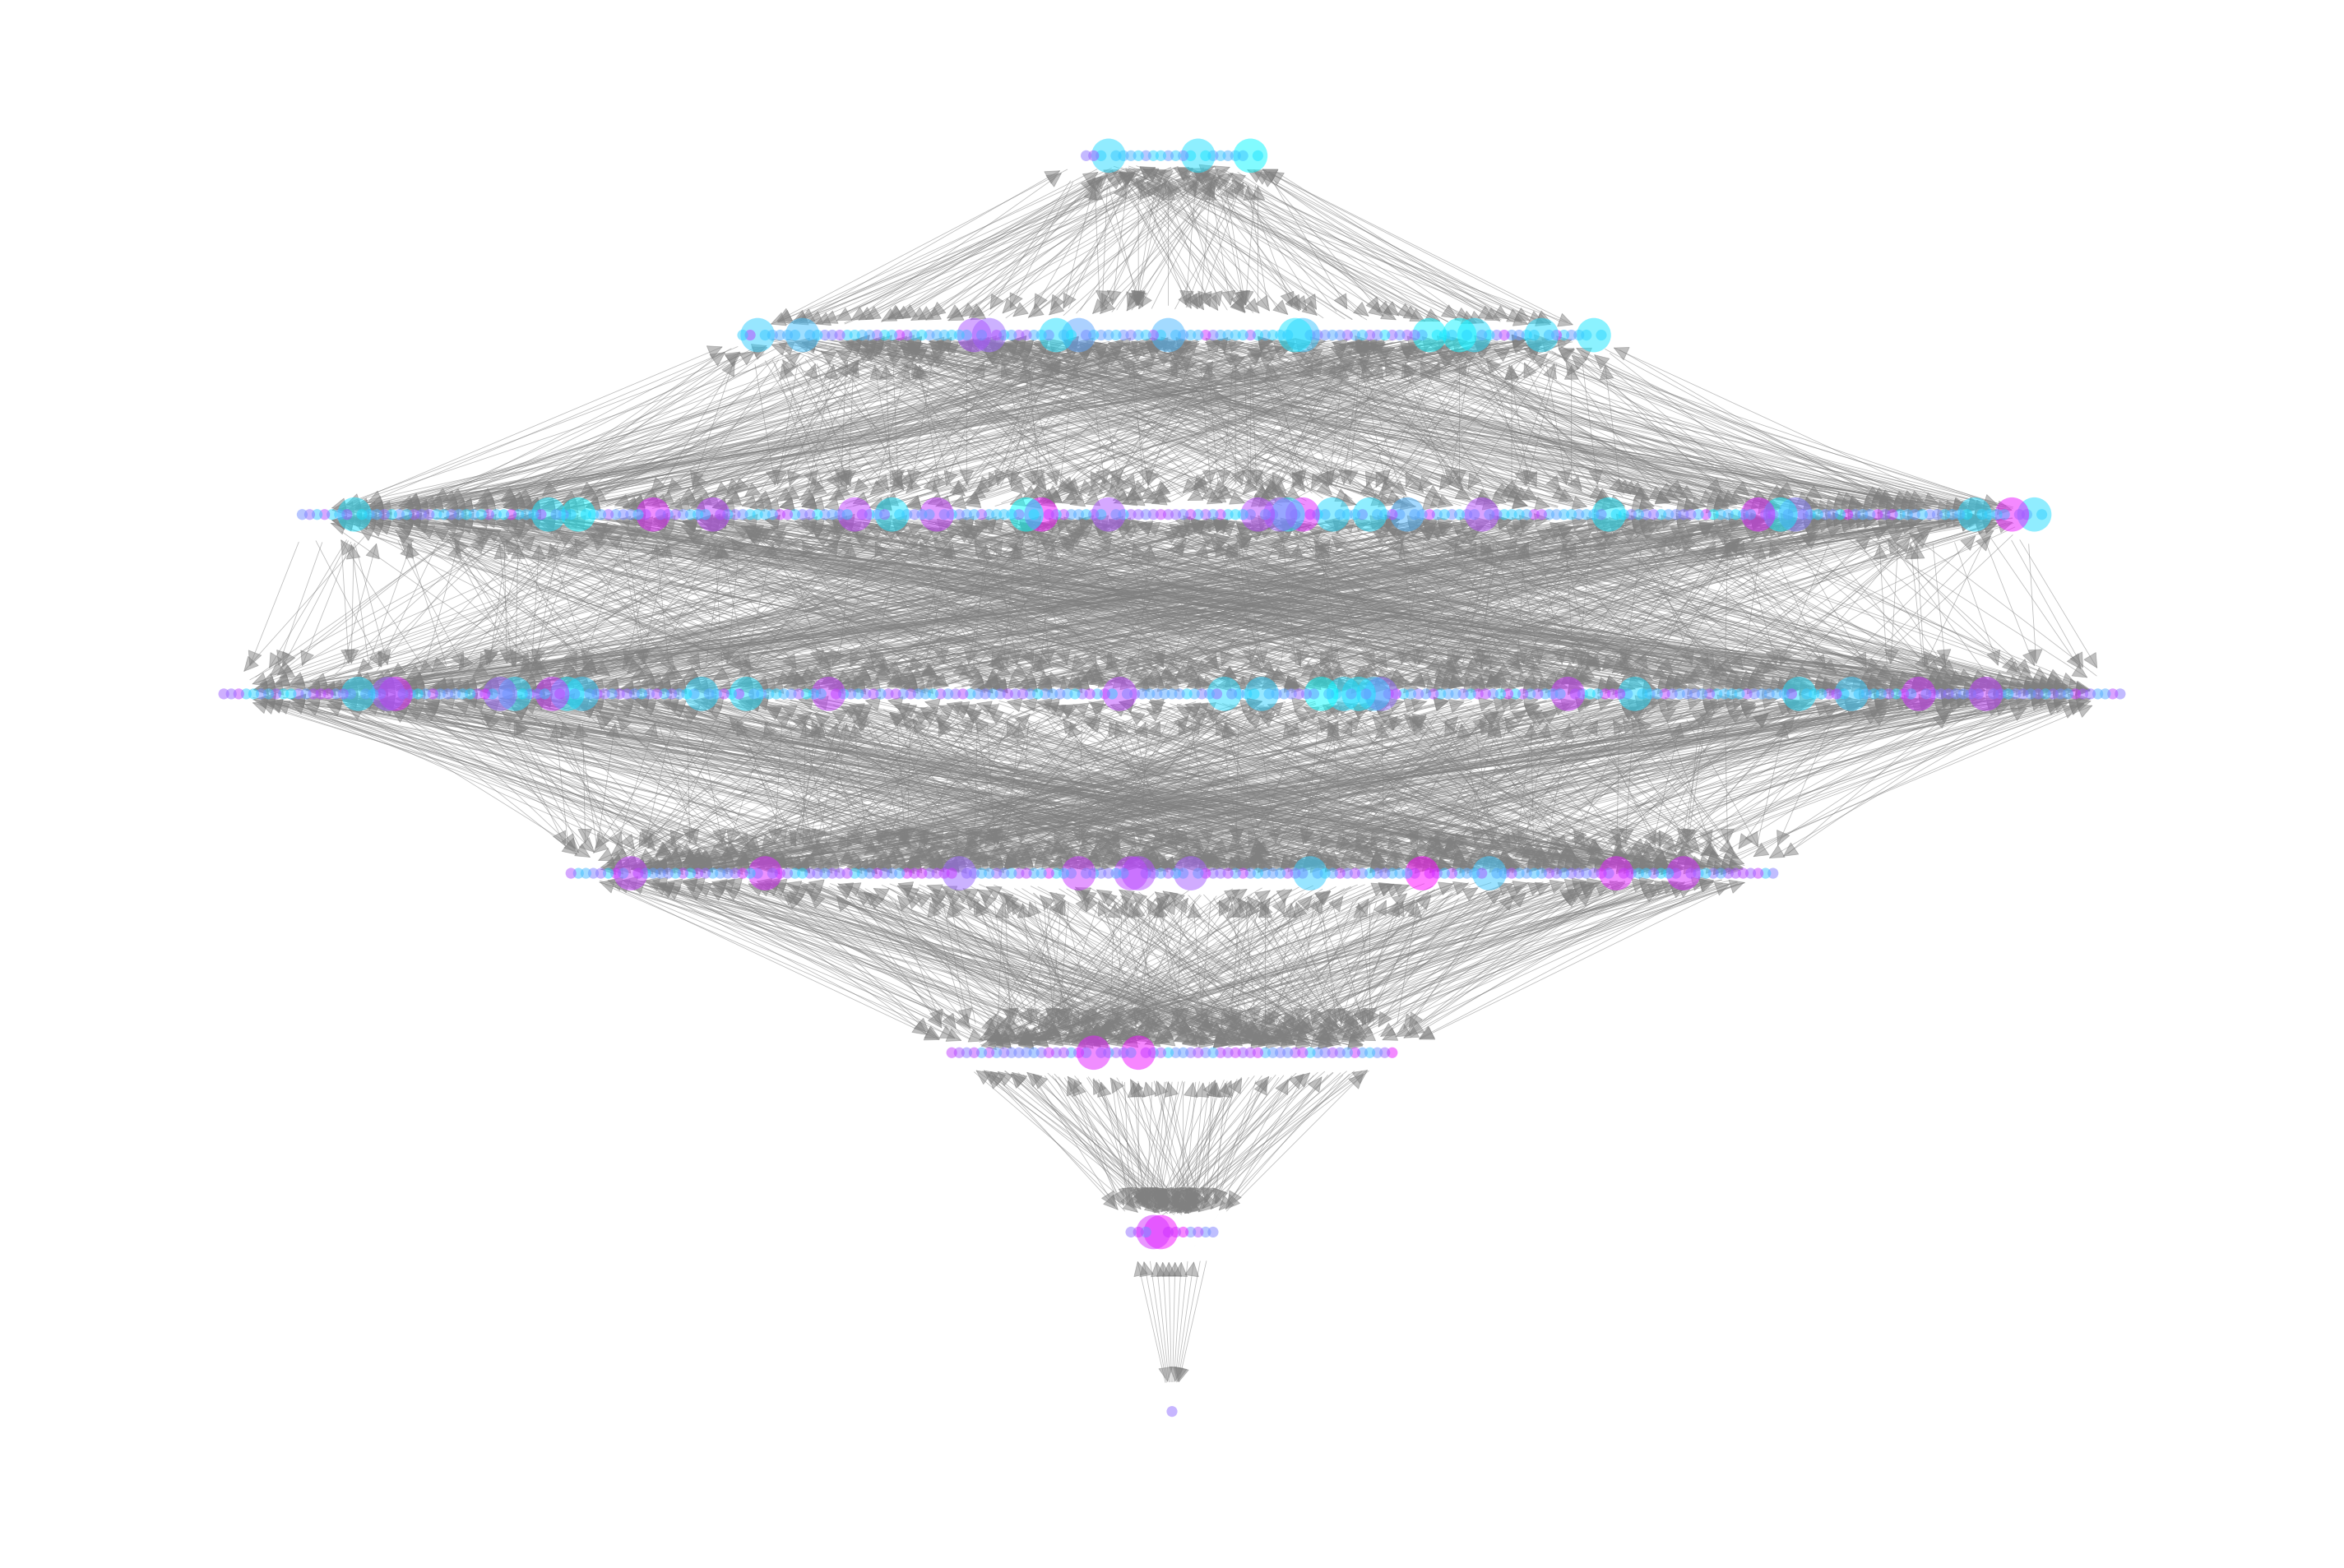

In [6]:
import matplotlib as mpl
import matplotlib.cm as cm

#print(DG)
# map fitness to color map
norm = mpl.colors.LogNorm(vmin=min(df['fit']), vmax=max(df['fit']))
mapper = cm.ScalarMappable(norm=norm, cmap=mpl.cm.cool)
NodeColors = [ mapper.to_rgba(DG.nodes[v]['fit']) for v in DG.nodes ]
ndEdgeColors = []
ndSizes = []
for x in DG.nodes:
    if x in peaks:
        ndEdgeColors.append("red")
        ndSizes.append(100)
    elif x in vals:
        ndEdgeColors.append("blue")
        ndSizes.append(100)
    else:
        ndEdgeColors.append("none")
        ndSizes.append(10)

#EdgeWidth = [ abs(DG.nodes[x[0]]['fit']-DG.nodes[x[1]]['fit'])*5 for x in DG.edges()]

pos = nx.multipartite_layout(DG, align = 'horizontal')
plt.figure(figsize = (12,8), dpi=300)
ec = nx.draw_networkx_edges(DG, pos, width = 0.2, edge_color = "gray", alpha = 0.5)
nc = nx.draw_networkx_nodes(DG, pos, 
                            node_color=NodeColors, 
                            node_size=ndSizes,
                            alpha = 0.5,
                            edgecolors="none"
                            )
plt.axis('off')
#plt.show()
plt.savefig("na.png")

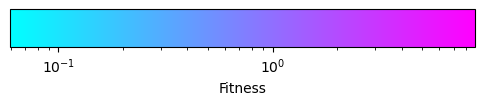

In [5]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.cool
#norm = mpl.colors.Normalize(vmin=5, vmax=10)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Fitness')
plt.savefig("na-colorbar.pdf")